In [43]:
import json
import jiwer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from collections import Counter
import glob
import os


In [44]:
# Pre-compiled transformations and evaluators
_TRANSFORMATION = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords()
])
_ROUGE = Rouge()
_SMOOTH = SmoothingFunction().method4


def compute_metrics(ref: str, hyp: str) -> dict:
    """
    Compute WER, BLEU, and ROUGE-L for a single reference/hypothesis pair.
    """
    ref, hyp = ref.strip(), hyp.strip()
    wer = jiwer.wer(ref, hyp,
                   truth_transform=_TRANSFORMATION,
                   hypothesis_transform=_TRANSFORMATION)
    bleu = sentence_bleu([ref.split()], hyp.split(), smoothing_function=_SMOOTH)
    try:
        rouge_l = _ROUGE.get_scores(hyp, ref)[0]["rouge-l"]["f"]
    except Exception:
        rouge_l = None
    return {"token_error_rate": wer, "bleu_score": bleu, "rouge_l": rouge_l}


def enrich_results(results: list) -> list:
    """
    Add metric scores to each item in a results list.
    """
    for item in results:
        metrics = compute_metrics(item["expected_answer"], item["generated_answer"])
        item.update(metrics)
    return results

In [45]:
def load_json(path: str) -> list:
    with open(path, encoding="utf-8") as f:
        return json.load(f)


def save_json(path: str, data: list) -> None:
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)


def load_and_process(pairs: list) -> dict:
    """
    Load, enrich, and save result sets. Returns a dict of label → enriched list.
    """
    enriched = {}
    for label, infile, outfile in pairs:
        data = load_json(infile)
        enriched[label] = enrich_results(data)
        save_json(outfile, enriched[label])
    return enriched

In [46]:
def plot_histograms(datasets: dict, metric):
    """
    Plot histograms and KDEs of token error rates.
    datasets: mapping from (group,label) to list of WER floats.
    Expects keys like ('no_expert', 'basic'), etc.
    """
    # Extract all rates
    rates = {k: [d[metric] for d in v] for k, v in datasets.items()}

    # Global axis limits
    all_vals = np.concatenate(list(rates.values()))
    x_min, x_max = all_vals.min(), all_vals.max() * 1.1
    x_grid = np.linspace(x_min, x_max, 200)
    global_y_max = max(gaussian_kde(vals)(x_grid).max() for vals in rates.values()) * 1.8

    # Plot settings
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    config = [
        (('no_expert', 'basic'), 'No Expert (Básico)', 'skyblue', 'blue'),
        (('no_expert', 'advanced'), 'No Expert (Avanzado)', 'skyblue', 'blue'),
        (('no_expert', 'langchain'), 'No Expert (Langchain)', 'skyblue', 'blue'),
        (('expert', 'basic'), 'Expert (Básico)', 'orange', 'red'),
        (('expert', 'advanced'), 'Expert (Avanzado)', 'orange', 'red'),
        (('expert', 'langchain'), 'Expert (Langchain)', 'orange', 'red'),
    ]

    for ax, (key, title, hist_color, kde_color) in zip(axes.flatten(), config):
        vals = rates[key]
        kde = gaussian_kde(vals)
        ax.hist(vals, bins=10, density=True, alpha=0.6,
                color=hist_color, edgecolor='black', label=f'{title}')
        ax.plot(x_grid, kde(x_grid), color=kde_color, lw=2,
                label=f'KDE {title}')
        ax.set(title=f"Histograma {title} de Token Error Rate",
               xlabel="Token Error Rate", ylabel="Densidad",
               xlim=(x_min, x_max), ylim=(0, global_y_max))
        ax.legend()

    plt.tight_layout()
    plt.show()

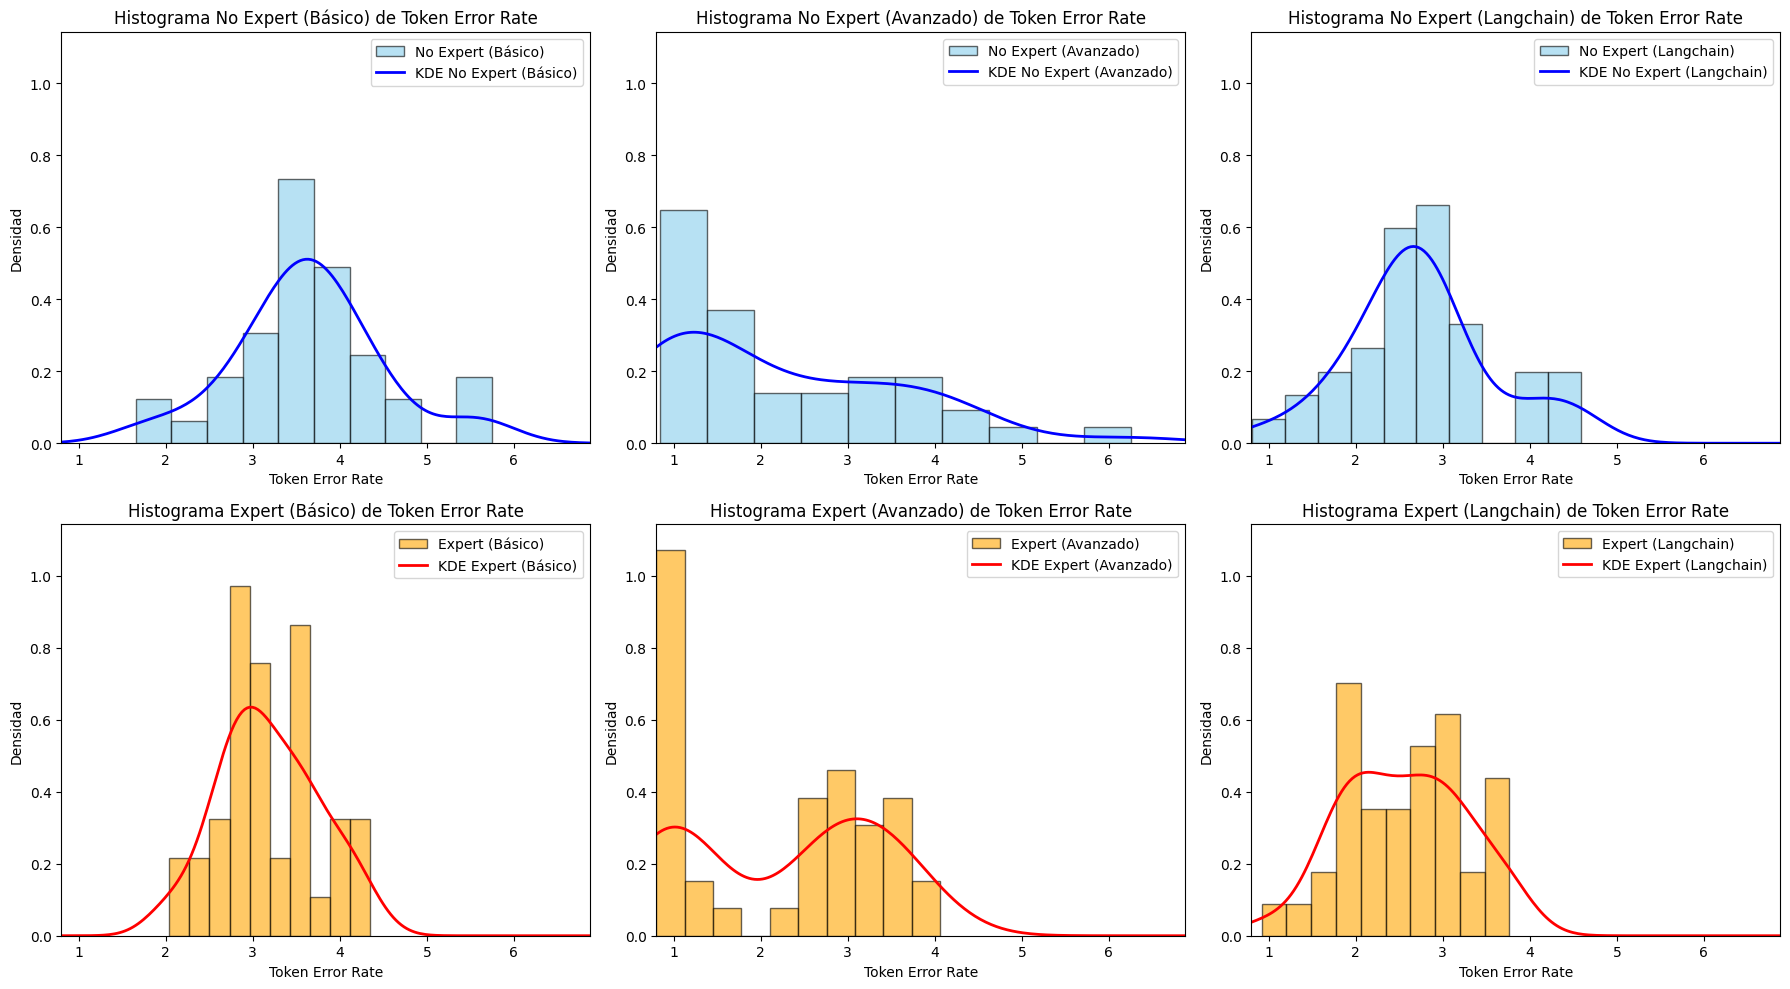

In [47]:

# Define file triads: (label, input path, output path)
basic = [
    ('basic_no_expert', 'nonExpert_results_basic.json', 'nonExpert_answers_basic.json'),
    ('basic_expert', 'expert_answers_basic.json',    'expert_results_basic.json')
]
advanced = [
    ('adv_no_expert', 'nonExpert_answers_advanced.json', 'nonExpert_answers_advanced.json'),
    ('adv_expert',   'expert_answers_advanced.json',     'expert_results_advanced.json')
]
langchain = [
    ('lang_no_expert', 'nonExpert_answers_langchain.json', 'nonExpert_answers_langchain.json'),
    ('lang_expert',    'expert_answers_langchain.json',    'expert_results_langchain.json')
]

# Process all sets
enriched = {}
enriched.update(load_and_process(basic))
enriched.update(load_and_process(advanced))
enriched.update(load_and_process(langchain))

# Plot distributions
# Map shortened keys to tuple keys
mapping = {
    ('no_expert', 'basic'):   enriched['basic_no_expert'],
    ('expert', 'basic'):      enriched['basic_expert'],
    ('no_expert', 'advanced'): enriched['adv_no_expert'],
    ('expert', 'advanced'):    enriched['adv_expert'],
    ('no_expert', 'langchain'): enriched['lang_no_expert'],
    ('expert', 'langchain'):    enriched['lang_expert'],
}
plot_histograms(mapping, 'token_error_rate')


In [50]:
# Diccionario resultado
scores_por_modelo = {}

# Localiza todos los archivos que siguen el patrón
for ruta in glob.glob("*_results_*_llm.json"):
    nombre_archivo = os.path.basename(ruta)

    # Ejemplo: "expert_results_basic_llm.json"
    # → partes = ["expert", "results", "basic", "llm.json"]
    partes = nombre_archivo.split("_")
    x = partes[0]                  # expert / nonExpert
    y = partes[2]                  # basic / advanced / langchain
    nombre_clave = f"{x} ({y})"    # "expert (basic)", p. ej.

    # Carga del JSON y extracción de llm_score
    with open(ruta, "r", encoding="utf-8") as f:
        registros = json.load(f)
    llm_scores = [fila["llm_score"] for fila in registros]

    # Añade al diccionario
    scores_por_modelo[nombre_clave] = llm_scores

print(scores_por_modelo)

{'expert (advanced)': [5, 3, 4, 4, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 3, 4, 3, 5, 5, 4, 3, 4, 3, 5, 5, 5, 5, 5, 5, 2, 5, 5, 3, 4, 4, 3, 2], 'expert (basic)': [5, 4, 4, 4, 3, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 2, 4, 5, 4, 5, 5, 5, 4, 4, 4, 5, 5, 4, 5, 5, 5, 5, 3, 4, 5, 3, 3, 3, 4, 5], 'expert (langchain)': [3, 3, 3, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 4, 5, 5, 4, 3, 4, 5], 'nonExpert (advanced)': [3, 4, 4, 4, 5, 5, 3, 4, 3, 5, 4, 4, 3, 5, 3, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 3, 5, 3, 3, 5, 3, 5, 5, 3, 5, 5, 5, 3], 'nonExpert (basic)': [3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3], 'nonExpert (langchain)': [4, 4, 4, 5, 5, 5, 5, 5, 5, 4, 3, 3, 5, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]}


In [51]:
orden = [
    "nonExpert (basic)",
    "nonExpert (advanced)",
    "nonExpert (langchain)",
    "expert (basic)",
    "expert (advanced)",
    "expert (langchain)",
]

etiquetas = [
    "1: Error al generar la respuesta",
    "2: Respuesta incorrecta",
    "3: Respuesta incompleta",
    "4: Respuesta mayormente correcta",
    "5: Respuesta totalmente correcta",
]
posiciones = range(1, 6)

# Contar frecuencias y hallar el máximo para escalar ejes
conteos = {}
max_y = 0
for nombre in orden:
    contador = Counter(scores_por_modelo.get(nombre, []))
    lista = [contador.get(i, 0) for i in posiciones]
    conteos[nombre] = lista
    max_y = max(max_y, max(lista))

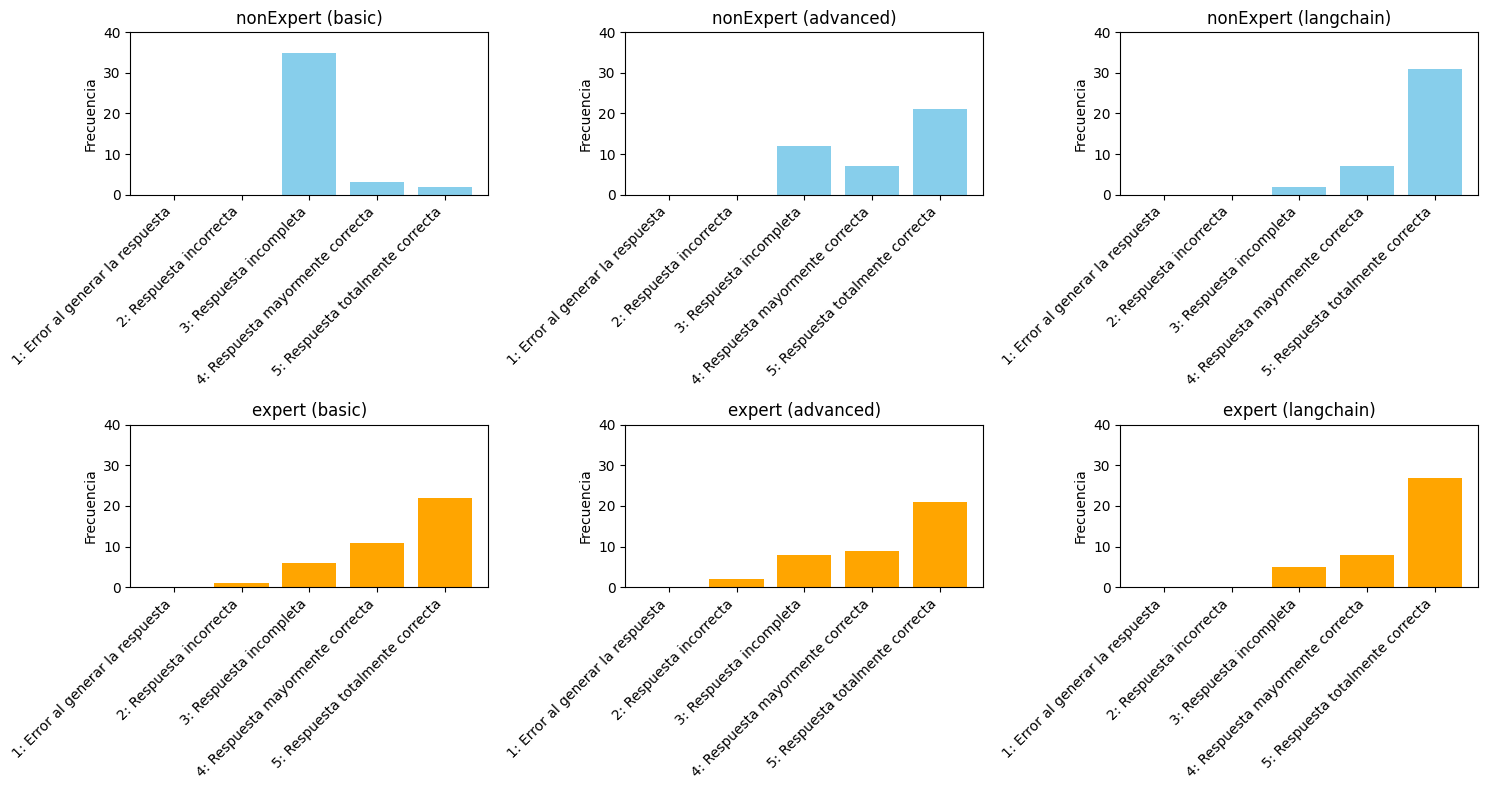

In [55]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharey=True)

for idx, nombre in enumerate(orden):
    fila, col = (0 if idx < 3 else 1), (idx % 3)
    ax = axs[fila, col]

    color = "skyblue" if "nonExpert" in nombre else "orange"
    ax.bar(posiciones, conteos[nombre], color=color)

    ax.set_xticks(posiciones)
    ax.set_xticklabels(etiquetas, rotation=45, ha="right")
    ax.set_title(nombre)
    ax.set_ylim(0, max_y + 5)

    # NUEVO → mostrar ticks y etiqueta Y en todos los subgráficos
    ax.tick_params(axis="y", labelleft=True)
    ax.set_ylabel("Frecuencia")

fig.tight_layout()
plt.show()